In [193]:
# plotting and data processing
import matplotlib as mpltlib
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn 
import numpy as np
import pandas as pd

# auxiliary 
import requests, re, json
from bs4 import BeautifulSoup
import datetime 
import math

# custom helpers
import rank_helper
import kimarite_helper

# ML tooling
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 10)

In [194]:
df = pd.read_csv(f'tournaments_all_final.csv')

# remove empty tournaments 
df = df[df.Forfeit != 15.0]

In [195]:
stats_df = pd.read_csv(f'stats_by_id.csv')
upper = df[df.Rank.apply(lambda x: rank_helper.rank_is_top(x))]

stats_df = stats_df[stats_df.n > 40]
# stats_df['m'][stats_df['m'] < -1] = -1
# stats_df['m'][stats_df['m'] > 1] = 1



In [196]:
full = pd.merge(upper, stats_df, on="id")


[Text(0.5, 1.0, 'm distribution'),
 Text(0.5, 0, 'score'),
 Text(0, 0.5, 'Count')]

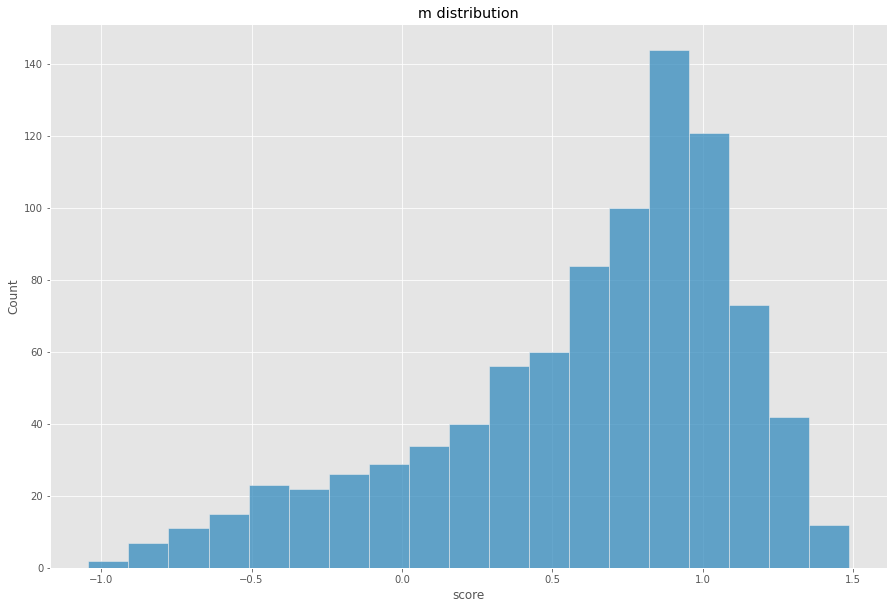

In [197]:
seaborn.histplot(data=stats_df, x="m").set(
        title='m distribution',
        xlabel='score',
        ylabel='Count') 

<br>

# Analysis with pusher metric

In [213]:
def push_class_logistic(data):
    
    # this is with accordance to the exploratory scraping in section 1
    pusherID = [12191,11985,8,12094,12043,11855,12239,5944,11934,7240]
    nonID = [11927,1123,12451,11868,1111,12107,12412,6599,11728,878,4,1]
    
    # initializing our training data
    for i, row in data.iterrows():
        if int(row['id']) in  pusherID:
            data.loc[i,"push_class_numeric"] = 0
        elif row['id'] in  nonID:
            data.loc[i,"push_class_numeric"] = 1

    # defining the training df
    df = data.loc[data['id'].isin(pusherID) | data['id'].isin(nonID)]

    # making our training set
    train_targ = df["push_class_numeric"].values
    train_feat = [[m] for m in df["m"]]
    
    # fitting the model
    lr = LogisticRegression()
    lr.fit(train_feat, train_targ)
   # print(lr.predict(test_feat)

    y_km = lr.predict([[m] for m in data["m"]])
    arr1 = ['Pusher' if i == 0 else 'Non-Pusher' for i in y_km]     
    return(arr1)
    
    
    

def push_class_kmeans(data, k):
    
    kmeans = KMeans(n_clusters = k)
    arr = [[0, i] for i in data['m']]
 
    y_km = kmeans.fit_predict(arr)
  
    return(y_km)





"\n\ndef push_class(score):\n    if score < -0.2:\n        return 'Full pusher'\n    elif score < 0:\n        return 'Moderate pusher'\n    elif score < 0.2:\n        return 'Moderate other'\n    else:\n        return 'Full other'\n"

In [199]:

#stats_df['push_class'] = stats_df.apply(lambda row: pusher_class(row.m) )
stats_df['push_class_numeric'] = np.nan
stats_df['push_class_LogisticRegression'] = push_class_logistic(stats_df)
stats_df['push_class_KMeans2'] = push_class_kmeans(stats_df, 2)
stats_df['push_class_KMeans3'] = push_class_kmeans(stats_df, 3)
stats_df['push_class_KMeans4'] = push_class_kmeans(stats_df, 4)


stats_df

,id,m,p,n,push_class_numeric,push_class_LogisticRegression,push_class_KMeans2,push_class_KMeans3,push_class_KMeans4
0,1.0,0.027626,0.490066,604.0,1.0,Pusher,1,0,0
1,2.0,1.220098,0.075798,752.0,NaN,Non-Pusher,0,1,1
2,3.0,0.536245,0.302682,522.0,NaN,Non-Pusher,0,2,3
3,4.0,0.160073,0.444142,734.0,1.0,Non-Pusher,1,2,0
4,5.0,1.253818,0.058140,688.0,NaN,Non-Pusher,0,1,1
...,...,...,...,...,...,...,...,...,...
1075,12449.0,-0.099929,0.548673,113.0,NaN,Pusher,1,0,0
1076,12451.0,0.707805,0.156522,115.0,1.0,Non-Pusher,0,2,3
1077,12453.0,-0.389437,0.702381,84.0,NaN,Pusher,1,0,2
1078,12470.0,-0.700176,0.865854,82.0,NaN,Pusher,1,0,2


Text(0.5, 1.0, 'Logistic Regression')

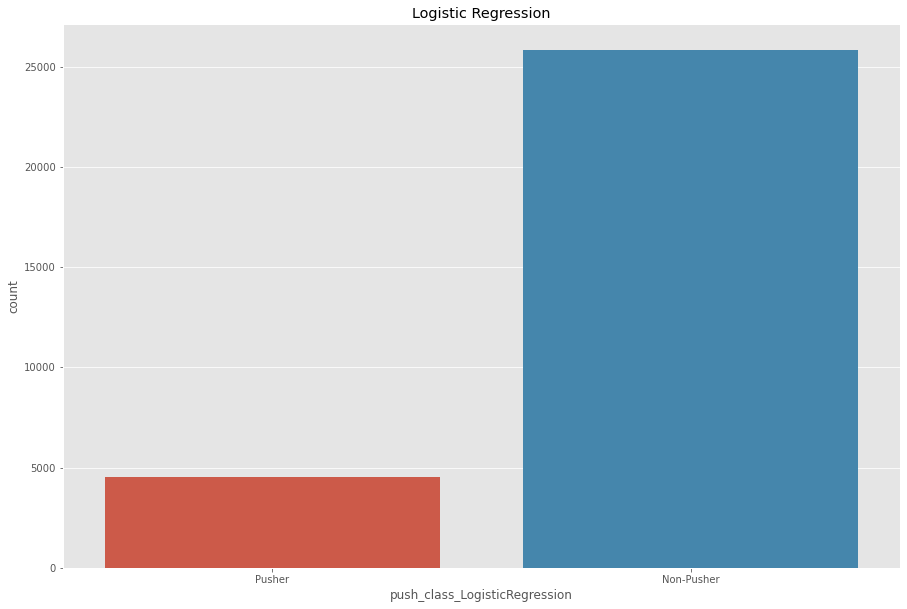

In [200]:
# note this is only a merge on the top two ranks
full = pd.merge(upper, stats_df, on="id")
full.dropna()

#seaborn.countplot(x="push_class", order=['Full pusher', 'Moderate pusher', 'Moderate other', 'Full other'], data=full)
ax = seaborn.countplot(x="push_class_LogisticRegression", order=['Pusher', 'Non-Pusher'], data=full)
ax.set_title("Logistic Regression")

[Text(0.5, 1.0, 'm distribution (logistic regression)'),
 Text(0.5, 0, 'score'),
 Text(0, 0.5, 'Count')]

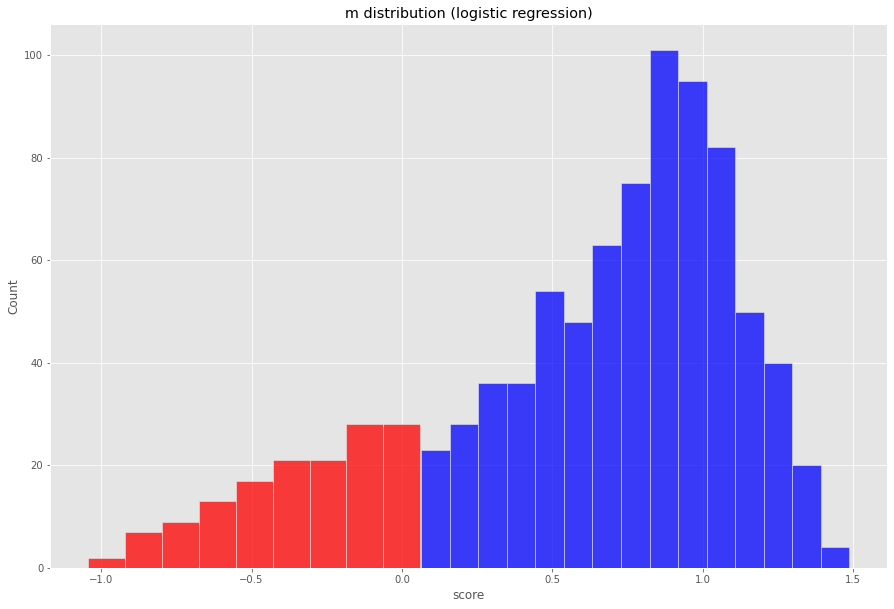

In [201]:
seaborn.histplot(data=stats_df.loc[stats_df['push_class_LogisticRegression'] == 'Pusher'], x="m", color="red").set(
        title='m distribution',
        xlabel='score',
        ylabel='Count') 

seaborn.histplot(data=stats_df.loc[stats_df['push_class_LogisticRegression'] == 'Non-Pusher'], x="m", color="blue").set(
        title='m distribution (logistic regression)',
        xlabel='score',
        ylabel='Count') 

Text(0.5, 1.0, 'KMeans (k=2)')

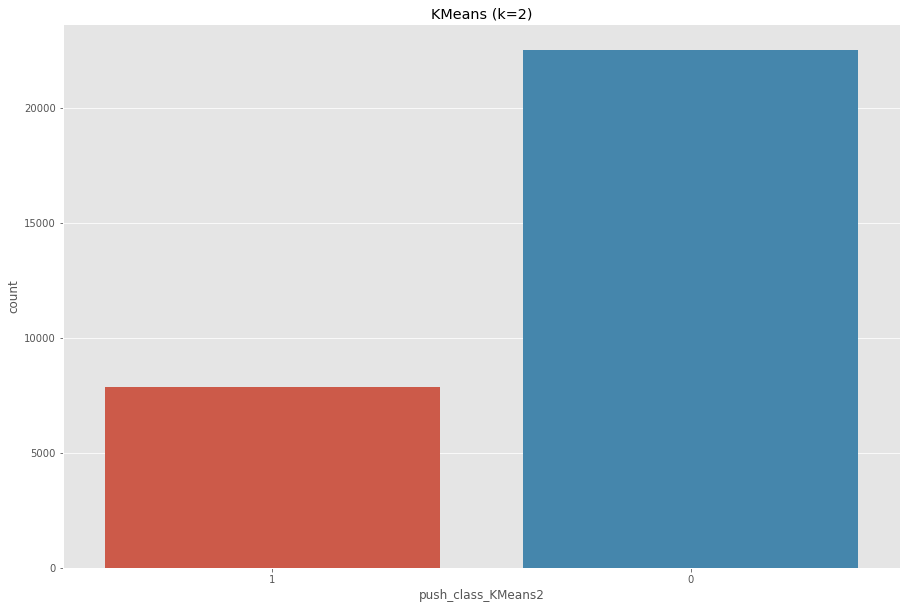

In [202]:
ax2 = seaborn.countplot(x="push_class_KMeans2", order=[1, 0], data=full)
ax2.set_title("KMeans (k=2)")

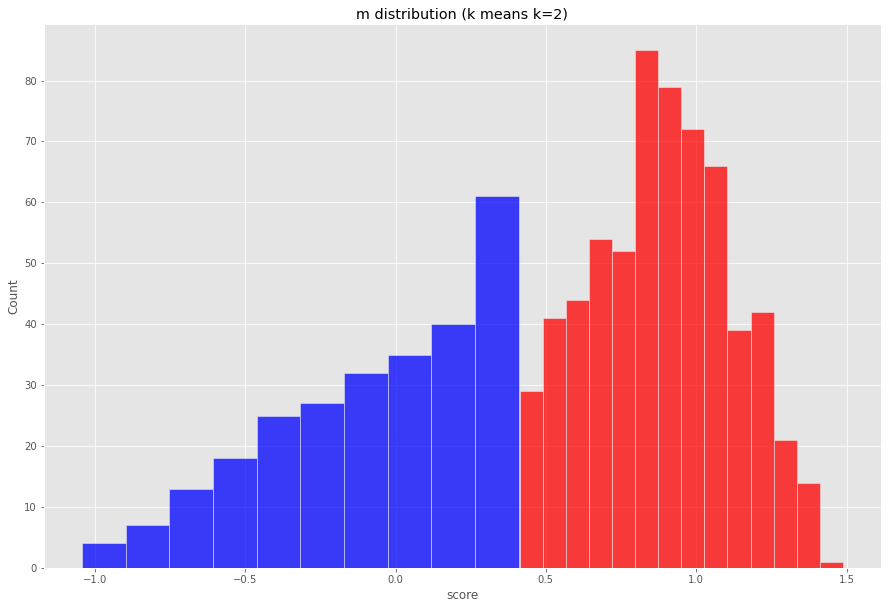

In [216]:
colors = ["red", "blue", "green", "orange"]

# the data should already be in the df
def make_kmeans_graph(k):
    for i in range(0, k):
        seaborn.histplot(data=stats_df.loc[stats_df[f'push_class_KMeans{k}'] == i], x="m", color=colors[i]).set(
                title=f'm distribution (k means k={k})',
                xlabel='score',
                ylabel='Count') 

make_kmeans_graph(2)

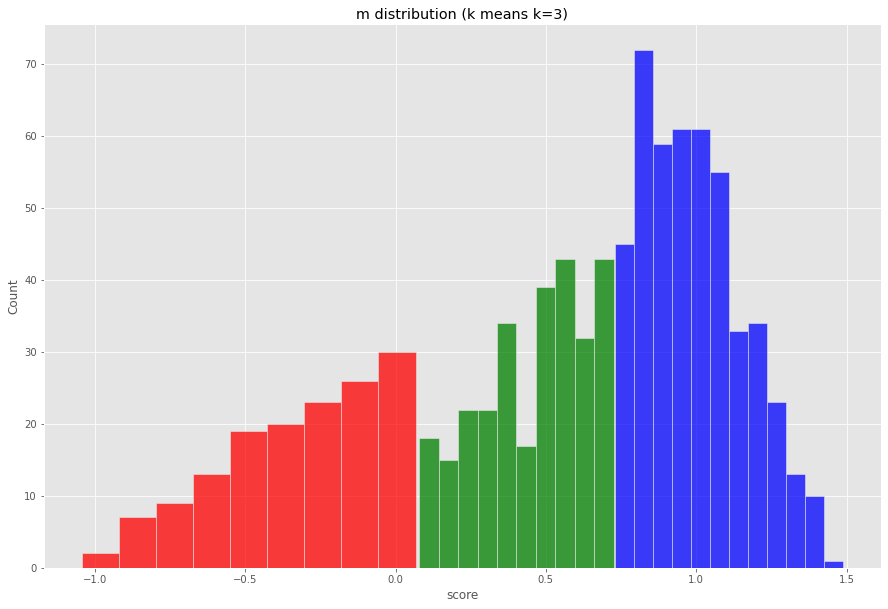

In [217]:
make_kmeans_graph(3)

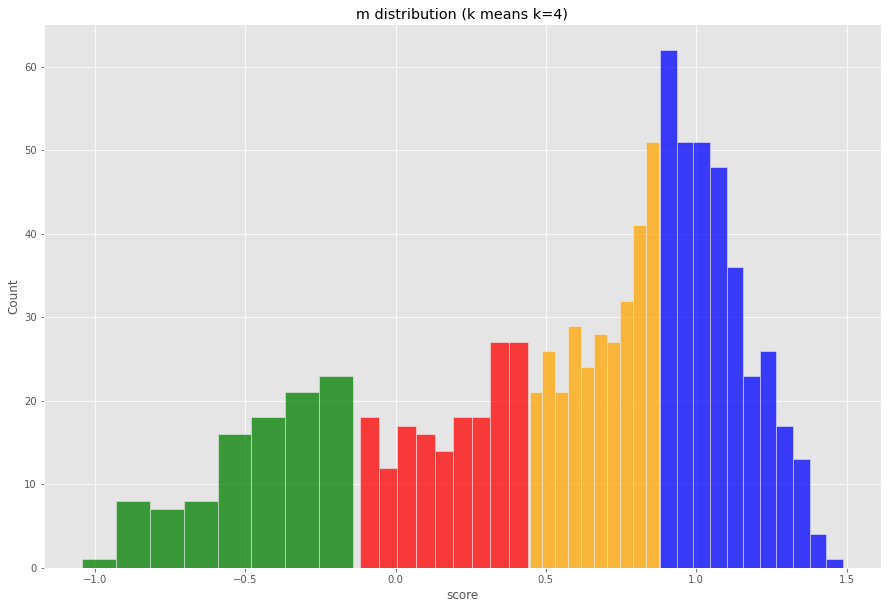

In [218]:
make_kmeans_graph(4)